# Gym CartPole-v1 w/Custom Reward CIP

https://arxiv.org/abs/2502.10097

Causal Information Prioritization for Efficient Reinforcement Learning

(from abstract)

Current Reinforcement Learning (RL) methods often suffer from sample-inefficiency, resulting from blind exploration strategies that neglect causal relationships among states, actions, and rewards. Although recent causal approaches aim to address this problem, they lack grounded modeling of reward-guided causal understanding of states and actions for goal-orientation, thus impairing learning efficiency. 

To tackle this issue, we propose a novel method named Causal Information Prioritization (CIP) that improves sample efficiency by leveraging factored MDPs to infer causal relationships between different dimensions of states and actions with respect to rewards, enabling the prioritization of causal information. 

In [1]:
!pip install gymnasium[mujoco]
!pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 14.0 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
import copy

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [3]:
class CausalInfoNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(CausalInfoNetwork, self).__init__()
        # Causal Model (Predicting State Transitions)
        self.causal_model = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim)
        )
        
        # Policy Network
        self.policy = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
        # Value Function
        self.value = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward_causal(self, state, action):
        # One-hot encoding for discrete actions
        action_one_hot = F.one_hot(action, num_classes=2).float()
        x = torch.cat([state, action_one_hot], dim=1)
        next_state_pred = self.causal_model(x)
        return next_state_pred
    
    def forward_policy(self, state):
        action_probs = F.softmax(self.policy(state), dim=-1)
        return action_probs
    
    def forward_value(self, state):
        value = self.value(state)
        return value
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action_probs = self.forward_policy(state)
        m = Categorical(action_probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

class ExperienceBuffer:
    def __init__(self, capacity=10000):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []
        self.log_probs = []
        self.capacity = capacity
        
    def add(self, state, action, reward, next_state, done, log_prob):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)
        self.log_probs.append(log_prob)
        
        # Remove old data when buffer capacity is exceeded
        if len(self.states) > self.capacity:
            self.states.pop(0)
            self.actions.pop(0)
            self.rewards.pop(0)
            self.next_states.pop(0)
            self.dones.pop(0)
            self.log_probs.pop(0)
            
    def get_batches(self, batch_size=64):
        indices = np.random.choice(len(self.states), batch_size, replace=False)
        return (
            torch.FloatTensor([self.states[i] for i in indices]),
            torch.LongTensor([self.actions[i] for i in indices]),
            torch.FloatTensor([self.rewards[i] for i in indices]),
            torch.FloatTensor([self.next_states[i] for i in indices]),
            torch.FloatTensor([self.dones[i] for i in indices]),
            torch.FloatTensor([self.log_probs[i] for i in indices])
        )
        
    def clear(self):
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()
        self.next_states.clear()
        self.dones.clear()
        self.log_probs.clear()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
class CIP:
    def __init__(self, env, state_dim=4, action_dim=2, hidden_dim=64, lr=0.001, gamma=0.99, 
                 batch_size=64, update_freq=2000, epsilon=0.2, causal_weight=0.5, verbose=1):
        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.update_freq = update_freq
        self.epsilon = epsilon
        self.causal_weight = causal_weight
        self.verbose = verbose
        
        # Environment dimension information
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # Initialize network and optimizer
        self.network = CausalInfoNetwork(state_dim, action_dim, hidden_dim)
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        
        # Initialize experience buffer
        self.buffer = ExperienceBuffer()
        
        # Learning step counter
        self.step_counter = 0
        
    def compute_returns(self, rewards, dones, last_value=0):
        returns = []
        R = last_value
        
        for reward, done in zip(reversed(rewards), reversed(dones)):
            R = reward + self.gamma * R * (1 - done)
            returns.insert(0, R)
            
        return returns
    
    def compute_causal_loss(self, states, actions, next_states):
        predicted_next_states = self.network.forward_causal(states, actions)
        causal_loss = F.mse_loss(predicted_next_states, next_states)
        return causal_loss
    
    def compute_policy_loss(self, states, actions, old_log_probs, returns, advantages):
        action_probs = self.network.forward_policy(states)
        dist = Categorical(action_probs)
        
        new_log_probs = dist.log_prob(actions)
        ratio = torch.exp(new_log_probs - old_log_probs)
        
        # PPO-style clipping
        clip_adv = torch.clamp(ratio, 1-self.epsilon, 1+self.epsilon) * advantages
        policy_loss = -torch.min(ratio * advantages, clip_adv).mean()
        
        # Entropy term (to encourage exploration)
        entropy = dist.entropy().mean()
        
        return policy_loss - 0.01 * entropy
    
    def compute_value_loss(self, states, returns):
        values = self.network.forward_value(states).squeeze()
        value_loss = F.mse_loss(values, returns)
        return value_loss
    
    def update(self):
        if len(self.buffer.states) < self.batch_size:
            return
            
        states, actions, rewards, next_states, dones, old_log_probs = self.buffer.get_batches(self.batch_size)
        
        # Compute returns and advantages
        with torch.no_grad():
            last_values = self.network.forward_value(next_states).squeeze()
            last_values[dones.bool()] = 0
            
        # Compute returns (since this is done per mini-batch instead of an entire episode, it's an approximation)
        returns = rewards + self.gamma * last_values * (1 - dones)
        advantages = returns - self.network.forward_value(states).squeeze().detach()
        
        # Causal model loss
        causal_loss = self.compute_causal_loss(states, actions, next_states)
        
        # Policy loss
        policy_loss = self.compute_policy_loss(states, actions, old_log_probs, returns, advantages)
        
        # Value function loss
        value_loss = self.compute_value_loss(states, returns)
        
        # Total loss (CIP feature: incorporates causal model loss with weighting)
        total_loss = policy_loss + 0.5 * value_loss + self.causal_weight * causal_loss
        
        # Optimization step
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()
        
        if self.verbose >= 2:
            print(f"Policy Loss: {policy_loss.item():.4f}, Value Loss: {value_loss.item():.4f}, "
                  f"Causal Loss: {causal_loss.item():.4f}")
    
    def collect_experience(self, n_steps=1000):
        state, _ = self.env.reset()
        episode_rewards = []
        current_ep_reward = 0
        
        for step in range(n_steps):
            # Select action
            action, log_prob = self.network.get_action(state)
            
            # Execute action in the environment
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            
            # Store experience
            self.buffer.add(state, action, reward, next_state, float(done), log_prob)
            
            # Update state
            state = next_state
            current_ep_reward += reward
            self.step_counter += 1
            
            # Handle episode termination
            if done:
                episode_rewards.append(current_ep_reward)
                current_ep_reward = 0
                state, _ = self.env.reset()
                
                if self.verbose >= 1 and len(episode_rewards) % 10 == 0:
                    avg_reward = sum(episode_rewards[-10:]) / min(len(episode_rewards), 10)
                    print(f"Episode {len(episode_rewards)}, Avg Reward: {avg_reward:.2f}")
            
            # Periodic update
            if self.step_counter % self.update_freq == 0:
                self.update()
        
        return episode_rewards
    
    def learn(self, total_timesteps=10000):
        n_updates = total_timesteps // self.update_freq
        
        for i in range(n_updates):
            if self.verbose >= 1:
                print(f"Update {i+1}/{n_updates}")
            
            # Collect experience and update model
            episode_rewards = self.collect_experience(self.update_freq)
            
            if self.verbose >= 1:
                avg_reward = sum(episode_rewards) / len(episode_rewards) if episode_rewards else 0
                print(f"Average episode reward: {avg_reward:.2f}")
        
        return self
    
    def predict(self, observation, deterministic=True):
        if deterministic:
            # Deterministic prediction
            state = torch.FloatTensor(observation).unsqueeze(0)
            action_probs = self.network.forward_policy(state)
            action = torch.argmax(action_probs, dim=1).item()
        else:
            # Stochastic action selection
            action, _ = self.network.get_action(observation)
        
        return action, None  # None is for state in case of recurrent policies

In [5]:
class CustomCartPoleEnv(gym.Env):
    """
    Custom version of the CartPole environment.
    Allows adjusting the permissible angle.
    """
    def __init__(self, max_angle_degrees=12.0, max_position=2.4, render_mode=None):
        self.max_angle = np.radians(max_angle_degrees)  # Convert degrees to radians
        self.max_position = max_position
        
        # Use the standard CartPole environment internally
        if hasattr(gym, 'make'):  # For the newer gymnasium version
            self.env = gym.make("CartPole-v1", render_mode=render_mode)
        else:  # For the older gym version
            self.env = gym.make("CartPole-v1")
        
        # Inherit environment settings
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        
        print(f"Created custom CartPole environment with:")
        print(f"- Max angle: ±{max_angle_degrees} degrees (±{self.max_angle:.4f} radians)")
        print(f"- Max position: ±{self.max_position}")
    
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def step(self, action):
        # Execute action in the environment
        if hasattr(self.env, 'unwrapped'):  # If using the gymnasium API
            obs, reward, terminated, truncated, info = self.env.step(action)
            
            # Check custom termination conditions and reward adjustments
            cart_position = obs[0]
            pole_angle = obs[2]
            
            # Continuous reward function based on angle
            # The closer the pole is to vertical, the higher the reward
            angle_factor = 1.0 - abs(pole_angle) / self.max_angle
            position_factor = 1.0 - abs(cart_position) / self.max_position
            
            # Calculate the reward considering both factors
            # Example: If the angle is more important, give a higher weight to angle_factor
            reward = 1.0 * (0.7 * angle_factor + 0.3 * position_factor)
            
            # Check termination conditions
            if abs(pole_angle) > self.max_angle or abs(cart_position) > self.max_position:
                terminated = True
                reward = 0  # Set reward to 0 upon termination
            
            return obs, reward, terminated, truncated, info
        else:  # If using the older gym API
            obs, reward, done, info = self.env.step(action)
            
            # Check custom termination conditions and reward adjustments
            cart_position = obs[0]
            pole_angle = obs[2]
            
            # Continuous reward function based on angle
            # The closer the pole is to vertical, the higher the reward
            angle_factor = 1.0 - abs(pole_angle) / self.max_angle
            position_factor = 1.0 - abs(cart_position) / self.max_position
            
            # Calculate the reward considering both factors
            # Example: If the angle is more important, give a higher weight to angle_factor
            reward = 1.0 * (0.7 * angle_factor + 0.3 * position_factor)
            
            # Check termination conditions
            if abs(pole_angle) > self.max_angle or abs(cart_position) > self.max_position:
                done = True
                reward = 0  # Set reward to 0 upon termination
            
            return obs, reward, done, info

    
    def render(self, mode="human"):
        if hasattr(self.env, 'render'):
            return self.env.render(mode)
        else:
            return self.env.render()
    
    def close(self):
        return self.env.close()

    env = gym.make("CartPole-v1")
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=10000)

In [6]:
def evaluate_model_with_custom_env(model, max_angle_degrees=12.0, max_position=2.4, max_steps=200, seed=42):
    """
    Evaluates a trained model in the custom CartPole environment.
    
    Parameters:
    model: Trained model (must have a predict function)
    max_angle_degrees: Maximum allowable angle (in degrees)
    max_position: Maximum allowable position
    max_steps: Maximum number of steps to execute
    seed: Random seed for reproducibility
    
    Returns:
    tuple: (observations, rewards, total_reward, termination_reason)
    """
    try:
        # Try importing gymnasium API
        import gymnasium
        render_mode = "rgb_array"
    except ImportError:
        render_mode = None
    
    # Create a custom environment
    env = CustomCartPoleEnv(max_angle_degrees=max_angle_degrees, 
                           max_position=max_position,
                           render_mode=render_mode)
    
    # Reset environment with a seed
    if hasattr(env, 'unwrapped'):  # For gymnasium API
        obs, info = env.reset(seed=seed)
    else:  # For older gym API
        obs = env.reset(seed=seed)
    
    # Initialize data collection
    observations = [obs]
    rewards = [0]  # No reward for the initial observation
    total_reward = 0
    termination_reason = "Reached maximum steps"
    
    # Run the episode
    for step in range(max_steps):
        # Get action from model
        action, _ = model.predict(obs, deterministic=True)
        
        # Execute action in the environment
        if hasattr(env, 'unwrapped'):  # For gymnasium API
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
        else:  # For older gym API
            obs, reward, done, info = env.step(action)
        
        # Store data
        observations.append(obs)
        rewards.append(reward)
        total_reward += reward
        
        # Explicitly check termination conditions
        cart_position = obs[0]
        pole_angle = obs[2]  # In radians
        pole_angle_degrees = np.degrees(pole_angle)
        
        # Print detailed state information
        print(f"Step {step+1}: Position={cart_position:.2f}, Angle={pole_angle_degrees:.2f}°, Reward={reward}, Total={total_reward}")
        
        if done:
            if abs(pole_angle_degrees) > max_angle_degrees:
                termination_reason = f"Pole angle exceeded ±{max_angle_degrees} degrees"
            elif abs(cart_position) > max_position:
                termination_reason = f"Cart exceeded track boundary (±{max_position})"
            else:
                termination_reason = "Environment sent termination signal"
            
            print(f"Episode ended: {termination_reason}")
            break
    
    env.close()
    print(f"Episode ended in {len(observations)-1} steps with a total reward of {total_reward}")
    
    return observations, rewards, total_reward, termination_reason

In [7]:
def visualize_cartpole(obs):
    """
    Convert CartPole observation to visualization coordinates
    
    Parameters:
    obs (array-like): CartPole observation [cart_position, cart_velocity, pole_angle, pole_angular_velocity]
    
    Returns:
    tuple: (cart_coords, pole_coords) - coordinates for visualization
    """
    cart_position = obs[0]
    pole_angle = obs[2]
    
    # Cart dimensions
    cart_width = 0.5
    cart_height = 0.25
    
    # Cart coordinates (rectangle)
    cart_left = cart_position - cart_width/2
    cart_right = cart_position + cart_width/2
    cart_bottom = 0
    cart_top = cart_height
    
    cart_coords = ([cart_left, cart_right, cart_right, cart_left, cart_left],
                  [cart_bottom, cart_bottom, cart_top, cart_top, cart_bottom])
    
    # Pole coordinates (line from cart center to pole end)
    pole_length = 1.0
    pole_x_start = cart_position
    pole_y_start = cart_height
    pole_x_end = pole_x_start + pole_length * np.sin(pole_angle)
    pole_y_end = pole_y_start + pole_length * np.cos(pole_angle)
    
    pole_coords = ([pole_x_start, pole_x_end], [pole_y_start, pole_y_end])
    
    return cart_coords, pole_coords

In [8]:
def evaluate_model_with_animation(env, model, n_episodes=1, deterministic=True, max_steps=500):
    """
    Function to execute evaluation and collect data for animation
    
    Parameters:
    env: Environment
    model: Trained CIP model
    n_episodes: Number of episodes to evaluate
    deterministic: Whether to use a deterministic policy
    max_steps: Maximum number of steps per episode
    
    Returns:
    list: Data from each episode (observations, rewards, total_reward, termination_reason)
    """
    all_episode_data = []
    
    for i in range(n_episodes):
        state, _ = env.reset()
        done = False
        truncated = False
        episode_reward = 0
        episode_steps = 0
        
        # Array for data collection
        episode_observations = [state]  # Include the initial state
        episode_rewards = []
        termination_reason = "Max Steps Reached"

        while not done and episode_steps < max_steps:
            action, _ = model.predict(state, deterministic=deterministic)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            episode_reward += reward
            episode_steps += 1
            
            # Record data
            episode_observations.append(next_state)
            episode_rewards.append(reward)
            
            # Record termination reason
            if terminated:
                # Identify the reason based on CartPole's termination conditions
                if abs(next_state[0]) > env.max_position:
                    termination_reason = "Cart Position Limit"
                elif abs(next_state[2]) > env.max_angle:
                    termination_reason = "Pole Angle Limit"
            elif truncated:
                termination_reason = "Environment Truncated"
            
            state = next_state
        
        print(f"Episode {i+1}: Steps = {episode_steps}, Reward = {episode_reward}, Reason: {termination_reason}")
        
        # Store episode data
        all_episode_data.append({
            'observations': episode_observations,
            'rewards': episode_rewards,
            'total_reward': episode_reward,
            'termination_reason': termination_reason
        })
    
    return all_episode_data

In [9]:
def animate_cartpole(episode_observations, rewards=None, total_reward=0, termination_reason=None):
    """
    Generate a 2D animation from CartPole-v1 observation data
    Parameters:
    episode_observations (list): Sequence of observation data from CartPole-v1
    rewards (list, optional): Rewards received at each step
    total_reward (float): Total accumulated reward
    termination_reason (str, optional): Reason for episode termination
    Returns:
    animation.FuncAnimation: The animation object
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Prepare lines for cart and pole
    cart_line, = ax.plot([], [], 'k-', linewidth=2)
    pole_line, = ax.plot([], [], 'r-', linewidth=3)
    
    # Calculate appropriate axis limits based on episode data
    max_cart_pos = max([abs(obs[0]) for obs in episode_observations]) + 1
    max_cart_pos = max(max_cart_pos, 2.5)  # Ensure we can see the track boundaries
    
    # Set axis limits and labels
    ax.set_xlim(-max_cart_pos, max_cart_pos)
    ax.set_ylim(-0.5, 2.5)
    ax.set_xlabel('Position')
    ax.set_ylabel('Height')
    
    # Add title with termination reason if provided
    title = 'CartPole-v1 Simulation'
    #title = f'CartPole-v1 Simulation - Total Reward: {total_reward}'
    if termination_reason:
        title += f' - Terminated: {termination_reason}'
    ax.set_title(title)
    
    # Draw the ground
    ground, = ax.plot([-max_cart_pos, max_cart_pos], [-0.2, -0.2], 'g-', linewidth=2)
    
    # Draw track boundaries
    left_boundary = ax.axvline(x=-2.4, color='red', linestyle='--', alpha=0.7, label='Track Boundary')
    right_boundary = ax.axvline(x=2.4, color='red', linestyle='--', alpha=0.7)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Text for state information
    state_text = ax.text(-max_cart_pos + 0.5, 2.2, '', fontsize=10)
    step_text = ax.text(max_cart_pos - 2, 2.2, '', fontsize=10, color='green')
    
    # Prepare cumulative reward data for display
    if rewards is None:
        cumulative_rewards = [0] * len(episode_observations)
    else:
        cumulative_rewards = [0]
        for i in range(1, len(rewards)):
            cumulative_rewards.append(cumulative_rewards[-1] + rewards[i-1])
    
    def init():
        cart_line.set_data([], [])
        pole_line.set_data([], [])
        state_text.set_text('')
        step_text.set_text('')
        return cart_line, pole_line, state_text, step_text
    
    def update(frame):
        # Get observation data for current frame
        obs = episode_observations[frame]
        
        # Calculate visualization coordinates
        cart_coords, pole_coords = visualize_cartpole(obs)
        
        # Update cart and pole positions
        cart_line.set_data(cart_coords)
        pole_line.set_data(pole_coords)
        
        # Update state text
        pole_angle_degrees = np.degrees(obs[2])
        state_info = f"Position: {obs[0]:.2f}, Velocity: {obs[1]:.2f}\nAngle: {pole_angle_degrees:.2f}°, Angular Vel: {obs[3]:.2f}"
        state_text.set_text(state_info)
        
        # Update step and reward info
        #step_info = f"Step: {frame}\nCumulative Reward: {cumulative_rewards[frame]}"
        #step_text.set_text(step_info)
        
        return cart_line, pole_line, state_text, step_text
    
    # Create animation
    anim = animation.FuncAnimation(
        fig, 
        update, 
        frames=len(episode_observations), 
        init_func=init, 
        blit=True, 
        interval=50,  # Update frames every 50 milliseconds
        repeat=True
    )
    
    # Save animation as GIF
    anim.save('CartPole-v1.gif', writer='pillow')
    
    plt.close(fig)
    print(f"Saved CartPole-v1 animation as 'CartPole-v1.gif'.")
    
    return anim

---

In [10]:
env = CustomCartPoleEnv(max_angle_degrees=12.0)

model = CIP(
    env=env,
    state_dim=4,
    action_dim=2,
    hidden_dim=64,
    lr=0.001,
    gamma=0.99,
    batch_size=64,
    update_freq=2000,
    epsilon=0.2,
    causal_weight=0.5,
    verbose=1
)

model.learn(total_timesteps=10000)

episode_data = evaluate_model_with_animation(env, model, n_episodes=200)

n_episodes=200
episode_observations=episode_data[n_episodes-1]['observations']
animate_cartpole(episode_observations)

Rewards=[]
for i in range(n_episodes):
    rewards=episode_data[i]['rewards']
    Rewards+=[sum(rewards)/len(rewards)]

Created custom CartPole environment with:
- Max angle: ±12.0 degrees (±0.2094 radians)
- Max position: ±2.4
Update 1/5
Episode 10, Avg Reward: 11.85
Episode 20, Avg Reward: 20.75
Episode 30, Avg Reward: 15.75
Episode 40, Avg Reward: 18.01
Episode 50, Avg Reward: 21.16
Episode 60, Avg Reward: 16.12
Episode 70, Avg Reward: 13.93
Episode 80, Avg Reward: 10.10
Episode 90, Avg Reward: 11.45


<ipython-input-3-96be0df33de8>:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  torch.FloatTensor([self.states[i] for i in indices]),


Average episode reward: 15.59
Update 2/5
Episode 10, Avg Reward: 12.95
Episode 20, Avg Reward: 16.04
Episode 30, Avg Reward: 9.56
Episode 40, Avg Reward: 14.13
Episode 50, Avg Reward: 13.23
Episode 60, Avg Reward: 14.68
Episode 70, Avg Reward: 20.07
Episode 80, Avg Reward: 16.60
Episode 90, Avg Reward: 14.17
Episode 100, Avg Reward: 11.33
Average episode reward: 14.28
Update 3/5
Episode 10, Avg Reward: 18.83
Episode 20, Avg Reward: 11.66
Episode 30, Avg Reward: 12.68
Episode 40, Avg Reward: 14.32
Episode 50, Avg Reward: 15.45
Episode 60, Avg Reward: 10.56
Episode 70, Avg Reward: 16.27
Episode 80, Avg Reward: 12.00
Episode 90, Avg Reward: 13.90
Average episode reward: 14.50
Update 4/5
Episode 10, Avg Reward: 17.79
Episode 20, Avg Reward: 12.47
Episode 30, Avg Reward: 18.72
Episode 40, Avg Reward: 14.82
Episode 50, Avg Reward: 16.10
Episode 60, Avg Reward: 13.82
Episode 70, Avg Reward: 17.42
Episode 80, Avg Reward: 18.58
Average episode reward: 16.60
Update 5/5
Episode 10, Avg Reward: 11

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


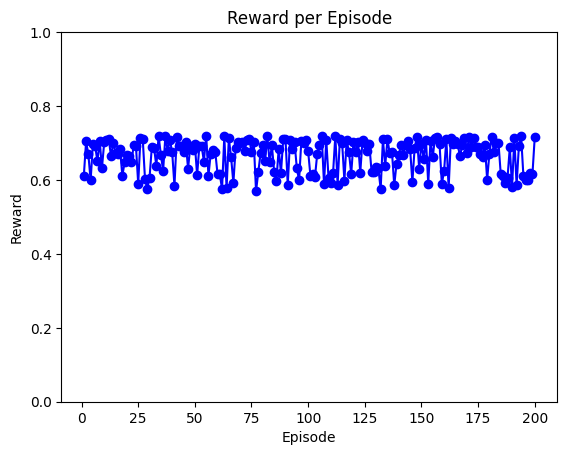

In [11]:
import matplotlib.pyplot as plt
episodes = list(range(1, n_episodes + 1))

plt.plot(episodes, Rewards, marker='o', linestyle='-', color='b')
plt.title("Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.ylim(0,1)
plt.show()

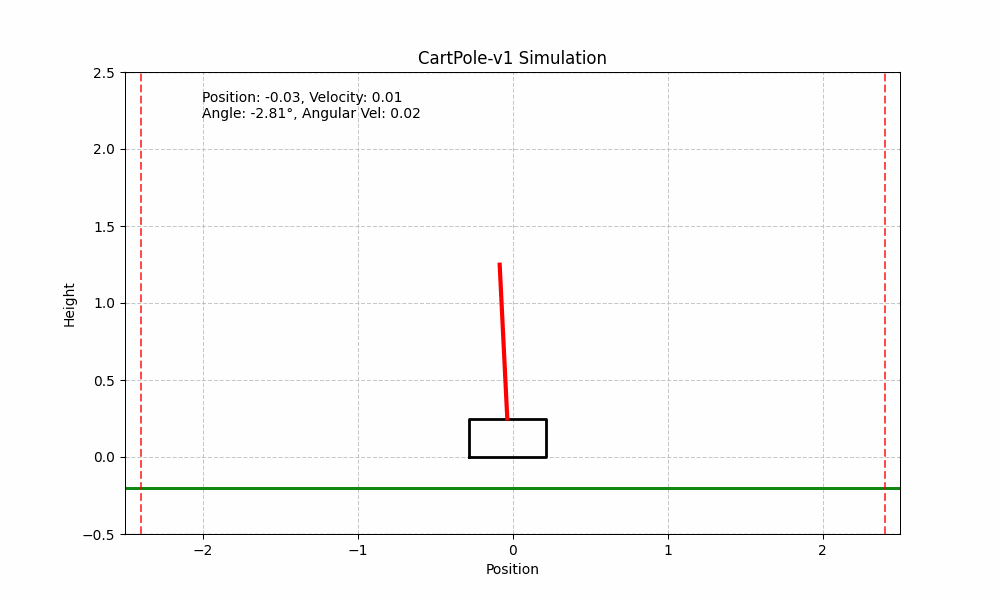

In [12]:
from IPython.display import Image
Image(open('./CartPole-v1.gif','rb').read())